In [1]:
import cv2 as cv
import cv2
import matplotlib.pyplot as plt
import numpy as np

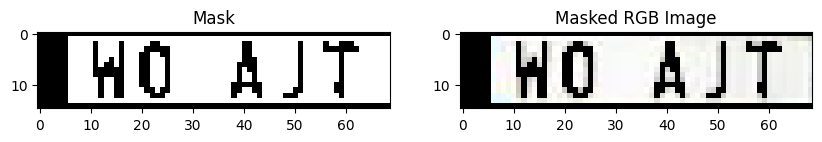

In [2]:
def create_mask(rgb_image):
    # Convert RGB image to HSV color space
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    # Define thresholds for each channel based on the provided values
    channel1_min = 0
    channel1_max = 180  # OpenCV uses 0-180 for hue
    channel2_min = 0
    channel2_max = int(0.129 * 255)
    channel3_min = int(0.781 * 255)
    channel3_max = 255
    
    # Create mask based on the defined thresholds
    mask = cv2.inRange(hsv_image, (channel1_min, channel2_min, channel3_min), (channel1_max, channel2_max, channel3_max))
    
    # Apply the mask to the original RGB image
    masked_rgb_image = cv2.bitwise_and(rgb_image, rgb_image, mask=mask)
    
    return mask, masked_rgb_image

# Example usage:
# Load RGB image
rgb_image = cv2.imread('plate.png')
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Call the function to create the mask
mask, masked_rgb_image = create_mask(rgb_image)

# Display the mask and masked RGB image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.subplot(1, 2, 2)
plt.imshow(masked_rgb_image)
plt.title('Masked RGB Image')

plt.show()


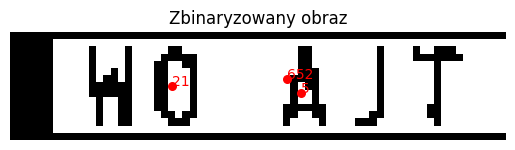

In [3]:
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(mask, connectivity=8)
# Wyświetlenie zbinaryzowanego obrazu
plt.imshow(mask, cmap='gray')
plt.title('Zbinaryzowany obraz')
plt.axis('off')

# Wyświetlenie składowych połączonych
for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    cx = int(centroids[i, 0])
    cy = int(centroids[i, 1])
    plt.text(cx, cy, str(area), color='red')
    plt.scatter(cx, cy, color='red', s=30)
    
plt.show()

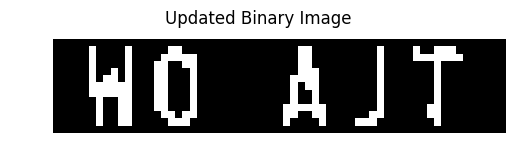

In [4]:
# Znajdź indeks centroidu z największym polem powierzchni (z pominięciem tła)
max_area_index = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

# Pobierz współrzędne centroidu o maksymalnym polu powierzchni
max_area_centroid = centroids[max_area_index]

updated_binary_image = np.copy(mask)
# Utwórz bounding box wokół centroidu z największym polem powierzchni
x, y, w, h = stats[max_area_index, cv.CC_STAT_LEFT], stats[max_area_index, cv.CC_STAT_TOP], stats[max_area_index, cv.CC_STAT_WIDTH], stats[max_area_index, cv.CC_STAT_HEIGHT]

# Wycięcie obszaru o największym polu powierzchni z binary_image
largest_component = np.zeros_like(mask)
largest_component[labels == max_area_index] = 255

# Nowa zmienna przechowująca obszary wewnątrz bounding boxa
updated_binary_image = np.copy(largest_component)

# Iteracja przez wszystkie etykiety poza tłem
for i in range(1, num_labels):
    area = stats[i, cv.CC_STAT_AREA]
    cx = int(centroids[i, 0])
    cy = int(centroids[i, 1])
    
    # Sprawdzenie, czy centroid obszaru znajduje się wewnątrz bounding boxa
    if x <= cx <= x + w and y <= cy <= y + h:
        # Jeśli tak, dodaj obszar do updated_binary_image
        updated_binary_image[labels == i] = 255

inverted_updated_binary_image = cv.bitwise_not(updated_binary_image)
# Wyświetlenie zaktualizowanego binarnego obrazu
plt.imshow(inverted_updated_binary_image, cmap='gray')
plt.title('Updated Binary Image')
plt.axis('off')
plt.show()


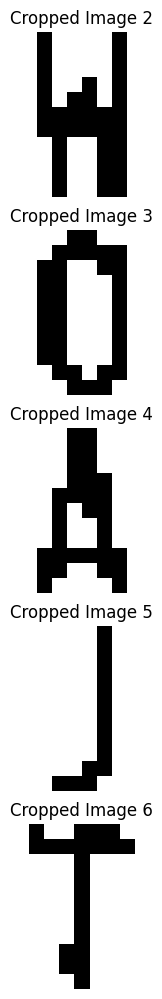

In [5]:
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(inverted_updated_binary_image, connectivity=8)

# Iterate through the connected components and display each cropped area except the largest
plt.figure(figsize=(15, 15))

for i in range(1, num_labels):
    if i == max_area_index:
        continue  # Skip the largest component
    
    x, y, w, h = stats[i, cv.CC_STAT_LEFT], stats[i, cv.CC_STAT_TOP], stats[i, cv.CC_STAT_WIDTH], stats[i, cv.CC_STAT_HEIGHT]
    cropped_image = inverted_updated_binary_image[y:y+h, x:x+w]
    cropped_image = cv.bitwise_not(cropped_image)
    plt.subplot(num_labels - 1, 1, i)
    plt.imshow(cropped_image, cmap='gray')
    plt.title(f'Cropped Image {i}')
    plt.axis('off')

plt.show()

In [6]:
def split(path):
    rgb_image = cv2.imread(path)
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    mask, masked_rgb_image = create_mask(rgb_image)
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(mask, connectivity=8)
    # Znajdź indeks centroidu z największym polem powierzchni (z pominięciem tła)
    max_area_index = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

    # Pobierz współrzędne centroidu o maksymalnym polu powierzchni
    max_area_centroid = centroids[max_area_index]

    updated_binary_image = np.copy(mask)
    # Utwórz bounding box wokół centroidu z największym polem powierzchni
    x, y, w, h = stats[max_area_index, cv.CC_STAT_LEFT], stats[max_area_index, cv.CC_STAT_TOP], stats[max_area_index, cv.CC_STAT_WIDTH], stats[max_area_index, cv.CC_STAT_HEIGHT]

    # Wycięcie obszaru o największym polu powierzchni z binary_image
    largest_component = np.zeros_like(mask)
    largest_component[labels == max_area_index] = 255

    # Nowa zmienna przechowująca obszary wewnątrz bounding boxa
    updated_binary_image = np.copy(largest_component)

    # Iteracja przez wszystkie etykiety poza tłem
    for i in range(1, num_labels):
        area = stats[i, cv.CC_STAT_AREA]
        cx = int(centroids[i, 0])
        cy = int(centroids[i, 1])
        
        # Sprawdzenie, czy centroid obszaru znajduje się wewnątrz bounding boxa
        if x <= cx <= x + w and y <= cy <= y + h:
            # Jeśli tak, dodaj obszar do updated_binary_image
            updated_binary_image[labels == i] = 255

    inverted_updated_binary_image = cv.bitwise_not(updated_binary_image)
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(inverted_updated_binary_image, connectivity=8)

    # Iterate through the connected components and display each cropped area except the largest
    plt.figure(figsize=(15, 15))

    for i in range(1, num_labels):
        if i == max_area_index:
            continue  # Skip the largest component
        
        x, y, w, h = stats[i, cv.CC_STAT_LEFT], stats[i, cv.CC_STAT_TOP], stats[i, cv.CC_STAT_WIDTH], stats[i, cv.CC_STAT_HEIGHT]
        cropped_image = inverted_updated_binary_image[y:y+h, x:x+w]
        cropped_image = cv.bitwise_not(cropped_image)
        print(cropped_image)
        plt.subplot(num_labels - 1, 1, i)
        plt.imshow(cropped_image, cmap='gray')
        plt.title(f'Cropped Image {i}')
        plt.axis('off')
        cv2.imwrite(f'{path}_croped_{i}.png', cropped_image)
    plt.show()
    
    
    

[[  0 255 255 255 255   0]
 [  0 255 255 255 255   0]
 [  0 255 255 255 255   0]
 [  0 255 255   0 255   0]
 [  0 255   0   0 255   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [255   0 255 255   0   0]
 [255   0 255 255   0   0]
 [255   0 255 255   0   0]
 [255   0 255 255   0   0]]
[[255 255   0   0 255 255]
 [255   0   0   0   0   0]
 [  0   0 255 255   0   0]
 [  0   0 255 255 255   0]
 [  0   0 255 255 255   0]
 [  0   0 255 255 255   0]
 [  0   0 255 255 255   0]
 [  0   0 255 255 255   0]
 [  0   0 255 255 255   0]
 [255   0   0 255   0   0]
 [255 255   0   0   0 255]]
[[255 255   0   0 255 255]
 [255 255   0   0 255 255]
 [255 255   0   0 255 255]
 [255 255   0   0   0 255]
 [255   0   0   0   0 255]
 [255   0 255   0   0 255]
 [255   0 255 255   0 255]
 [255   0 255 255   0 255]
 [  0   0   0   0   0   0]
 [  0   0 255 255   0   0]
 [  0 255 255 255 255   0]]
[[255 255 255   0]
 [255 255 255   0]
 [255 255 255   0]
 [255 255 255   0]
 [255 255 255   0]
 [255 255 2

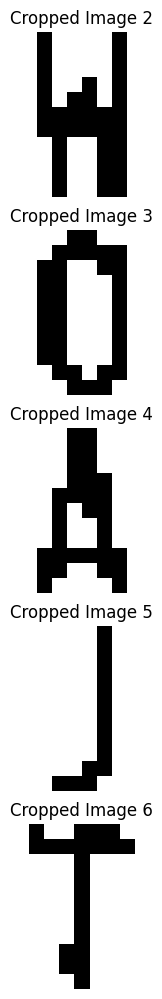

In [7]:
split("plate.png")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


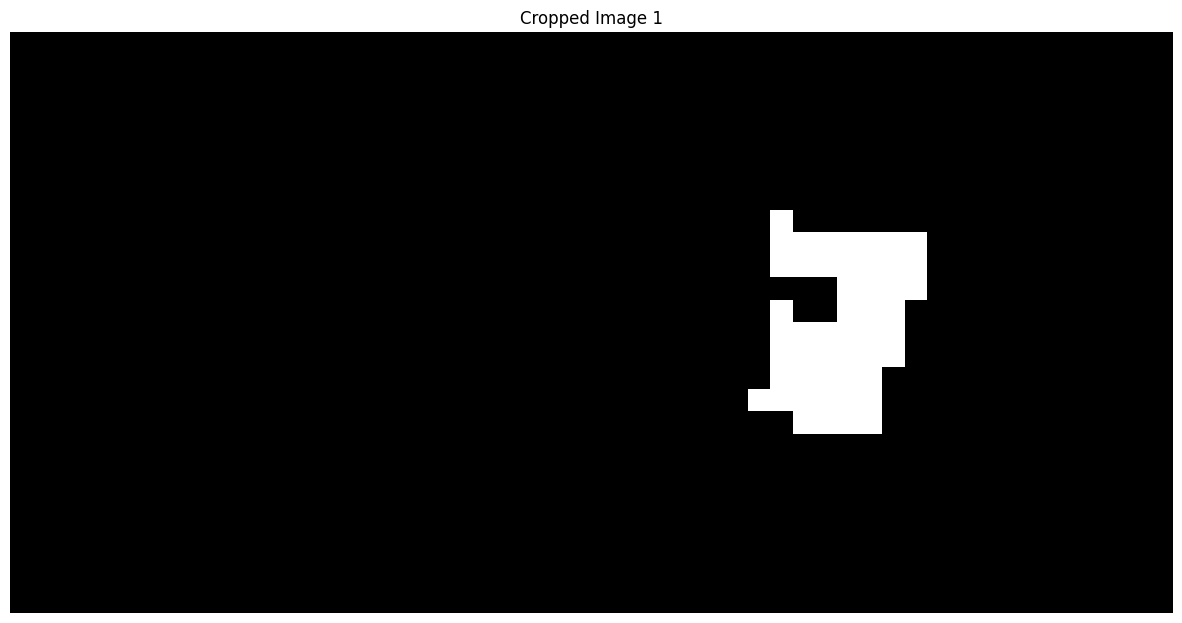

In [8]:
split("plate2.png")

In [9]:
split("plate3.png")

ValueError: attempt to get argmax of an empty sequence

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 255   0   0 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255 255   0
    0 255 255   0   0 255 255 255 255   0   0 255 255 255 255 255   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255 25

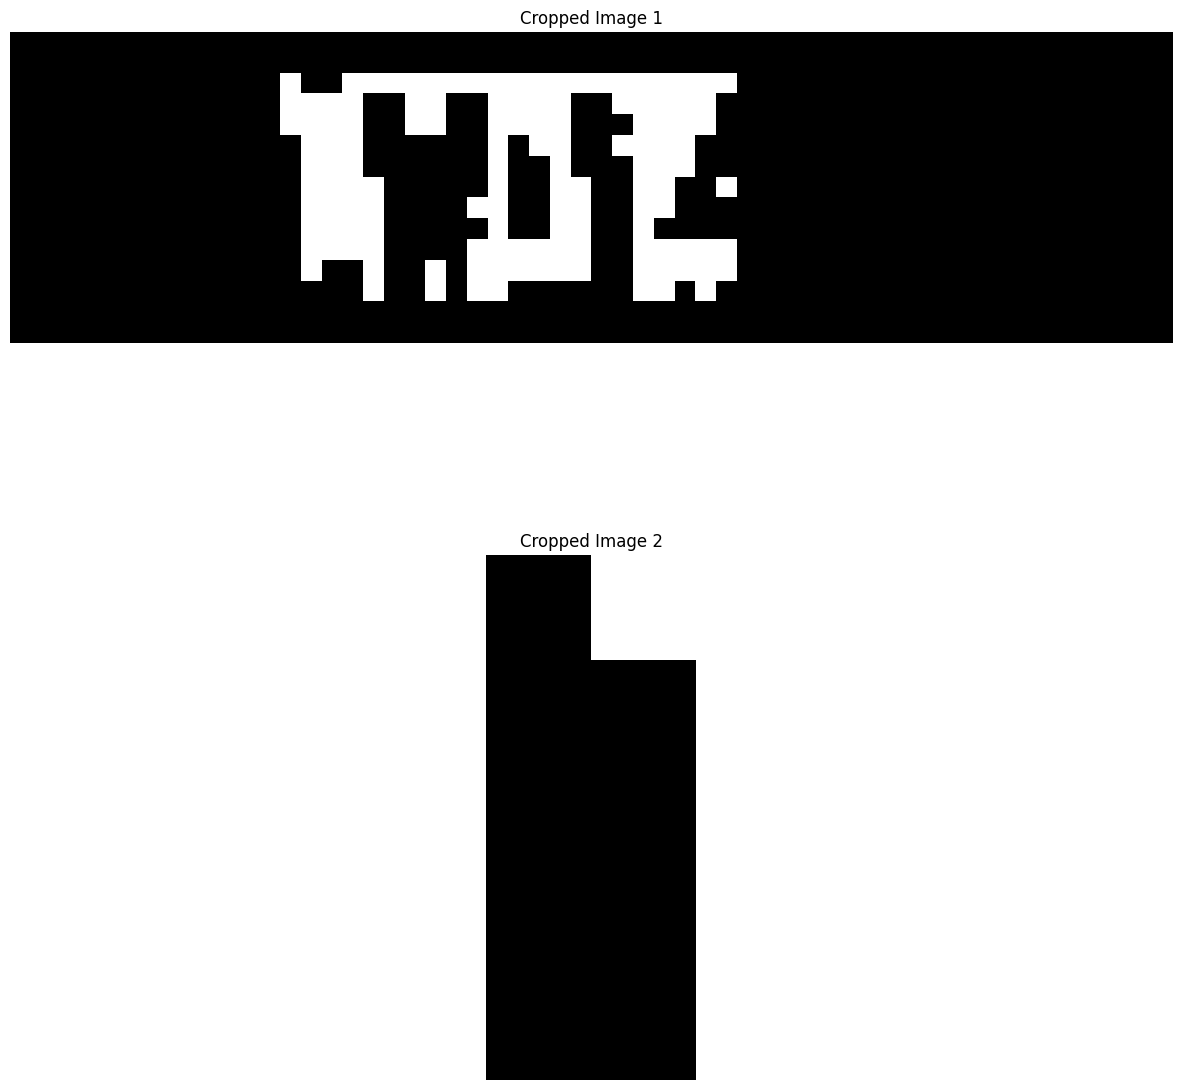

In [10]:
split("plate4.png")

In [11]:
from tensorflow.config.experimental import list_physical_devices,set_memory_growth
# Get the list of GPUs
gpus = list_physical_devices('GPU')

if gpus:
    try:
        # Allow GPU memory growth
        for gpu in gpus:
            set_memory_growth(gpu, True)
        print("GPU memory growth set successfully.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available.")

2024-05-28 11:24:15.329571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 11:24:17.134903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU memory growth set successfully.


2024-05-28 11:24:18.590629: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 11:24:18.635339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 11:24:18.635421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


https://www.tensorflow.org/tutorials/images/classification

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Wczytywanie danych z katalogu
data_dir = 'data_classificator'
batch_size = 32
img_height = 28
img_width = 28

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode='grayscale',  # Ustawienie na obrazy jednokanałowe
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode='grayscale',  # Ustawienie na obrazy jednokanałowe
    image_size=(img_height, img_width),
    batch_size=batch_size
)


2024-05-29 10:47:08.107957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 10:47:14.660162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 720 files belonging to 36 classes.
Using 576 files for training.


2024-05-29 10:47:31.653925: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 10:47:33.930029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 10:47:33.930106: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 10:47:33.931188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 10:47:33.931247: I external/local_xla/xla/stream_executor

Found 720 files belonging to 36 classes.
Using 144 files for validation.


In [2]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


2024-05-29 10:47:47.196307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


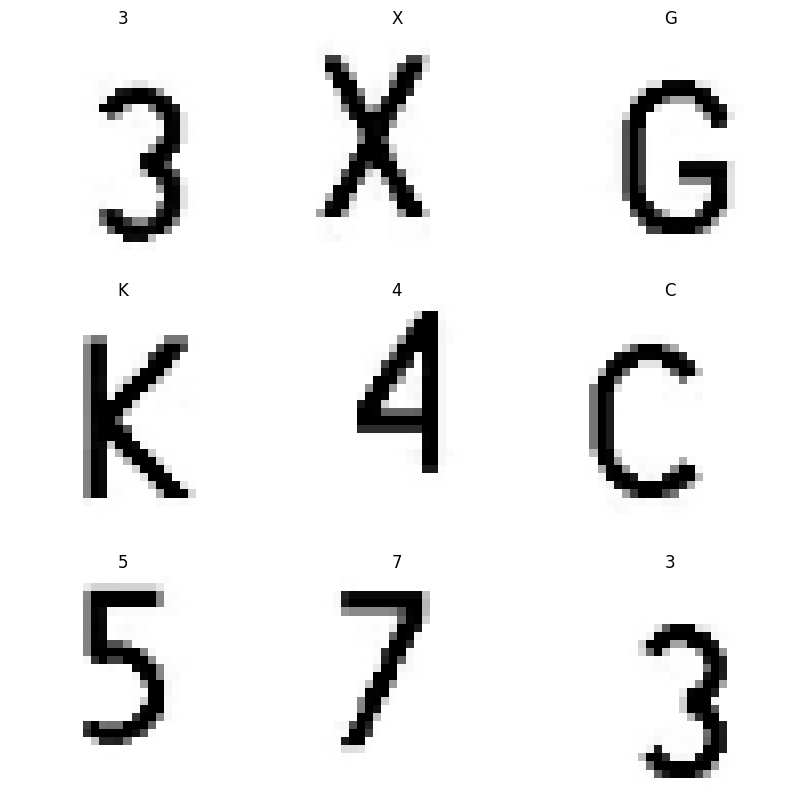

In [3]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 28, 28, 1)
(32,)


In [21]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom , Lambda, Reshape, Resizing, Rescaling
from keras_cv.layers import RandomShear



data_augmentation = tf.keras.Sequential([
    # RandomFlip("horizontal_and_vertical"),
    Rescaling(1./255,input_shape=(img_height,
                                  img_width,
                                  1)),
    
    RandomRotation(0.03),
    RandomShear((0.2,0.2)),
    Resizing(img_height, img_width),
    RandomZoom(0.2),
])

data_augmentation.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_7               │ (None, 28, 28, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_shear_7 (RandomShear)    │ (None, None, None, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_7 (Resizing)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_7 (RandomZoom)      │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

[0.01121849 0.01306032 0.02159622 0.02869125 0.03065884 0.04001632
 0.04267868 0.04840026 0.05056961 0.05287762 0.06732924 0.07207856
 0.07233638 0.07564855 0.08114528 0.08426927 0.08510076 0.08694127
 0.08735774 0.08800469 0.08806486 0.08889442 0.08967371 0.09005719
 0.09456102 0.09714425 0.0977369  0.09927587 0.10360567 0.11842676
 0.1208645  0.12530692 0.12897015 0.12970532 0.13625097 0.14786148
 0.15246181 0.15605737 0.16193075 0.16565275 0.17785586 0.1779428
 0.1803583  0.18166323 0.18199897 0.18204063 0.18714757 0.18834662
 0.19281578 0.1936481  0.1962535  0.20323037 0.21016721 0.22235885
 0.22274978 0.22551915 0.23973344 0.2528948  0.25334722 0.26053184
 0.2642353  0.26998803 0.27606675 0.277028   0.27902338 0.27928174
 0.28056633 0.2865158  0.29544085 0.29720393 0.29878864 0.30232275
 0.3026123  0.30680975 0.31055015 0.31409568 0.3167123  0.31671762
 0.3192532  0.3216902  0.3308055  0.34356138 0.34368497 0.34879136
 0.35189354 0.35601962 0.36677402 0.3753358  0.37883642 0.38519

2024-05-29 11:02:22.036773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(-0.5, 27.5, 27.5, -0.5)

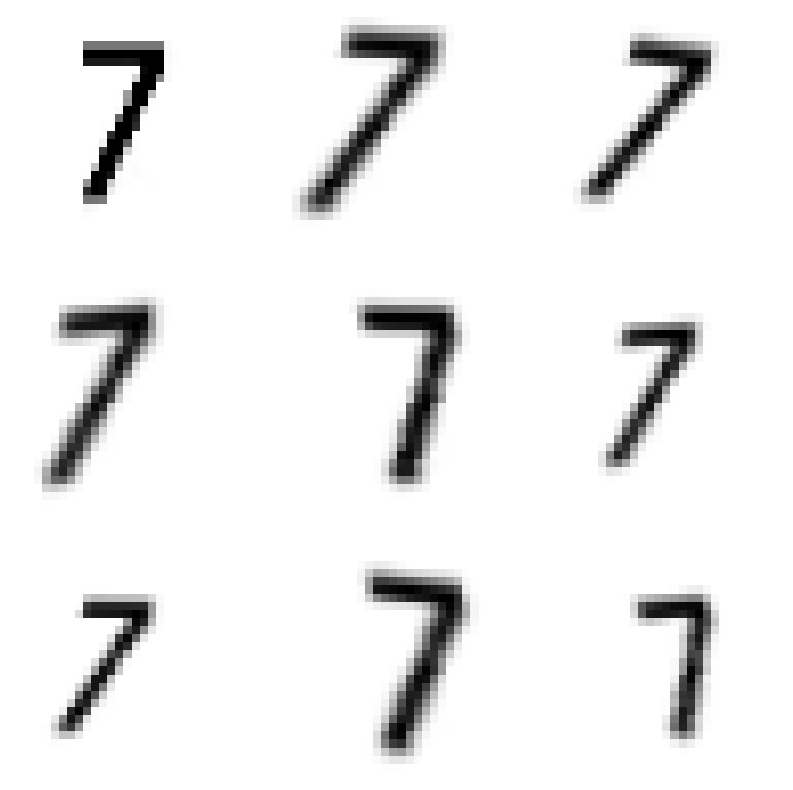

In [23]:
import numpy as np
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    
    augmented_images = data_augmentation(images)
    print(np.unique((augmented_images[0].numpy())))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy(),cmap='gray')
    
    plt.axis("off")
    
plt.subplot(3, 3, 1)
plt.imshow(images[0].numpy(), cmap='gray')
plt.axis("off")

In [18]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Definiowanie zmiennych
kernel_regularizer = regularizers.l2(0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
loss_function = 'sparse_categorical_crossentropy'

model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.BatchNormalization(),
    #layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=kernel_regularizer),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(train_ds.class_names), activation='softmax')
])

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Definiowanie callbacków
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    f"models/best_model_{now}.keras", 
    monitor="val_accuracy", 
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.1, 
    patience=5)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

epochs = 300

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs, 
    callbacks=callbacks
)

# Ocena modelu
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy*100:.2f}%")

Epoch 1/300


2024-05-28 11:24:37.591663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-28 11:24:38.789949: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 307ms/step - accuracy: 0.0446 - loss: 5116.7656 - val_accuracy: 0.0347 - val_loss: 1157.8710 - learning_rate: 0.1000
Epoch 2/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.0374 - loss: 810.6302 - val_accuracy: 0.0278 - val_loss: 293.7014 - learning_rate: 0.1000
Epoch 3/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.0466 - loss: 225.8398 - val_accuracy: 0.0069 - val_loss: 166.7656 - learning_rate: 0.1000
Epoch 4/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.0619 - loss: 146.6350 - val_accuracy: 0.0417 - val_loss: 160.1422 - learning_rate: 0.1000
Epoch 5/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.0647 - loss: 138.9755 - val_accuracy: 0.0139 - val_loss: 152.5306 - learning_rate: 0.1000
Epoch 6/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.0533 - loss: 147.2703 - val_accuracy: 0.0278 - val_loss: 727.3704 - learning_rate: 0.1000
Epoch 7/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.

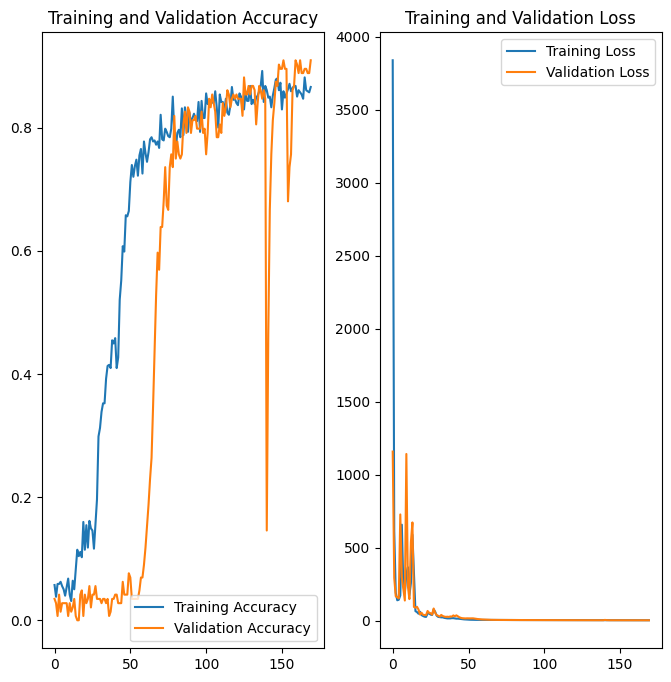

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
path="plate.png_croped_6.png"
img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width), color_mode='grayscale'
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This image most likely belongs to 2 with a 3.36 percent confidence.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

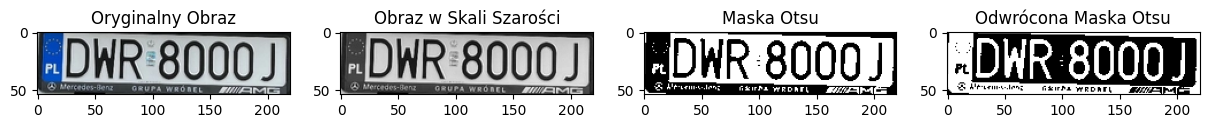

In [69]:
# Wczytaj obraz
image_path = 'better_data/plate/image_02.png'
image = cv2.imread(image_path)

# Konwersja obrazu na skalę szarości
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Zastosowanie filtru Otsu do progowania
_, otsu_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

otsu_mask_reversed = cv2.bitwise_not(otsu_mask)

# Opcjonalnie: Pokaż wyniki
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.title('Oryginalny Obraz')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 4, 2)
plt.title('Obraz w Skali Szarości')
plt.imshow(gray_image, cmap='gray')

plt.subplot(1, 4, 3)
plt.title('Maska Otsu')
plt.imshow(otsu_mask, cmap='gray')

plt.subplot(1, 4, 4)
plt.title('Odwrócona Maska Otsu')
plt.imshow(otsu_mask_reversed, cmap='gray')

plt.show()

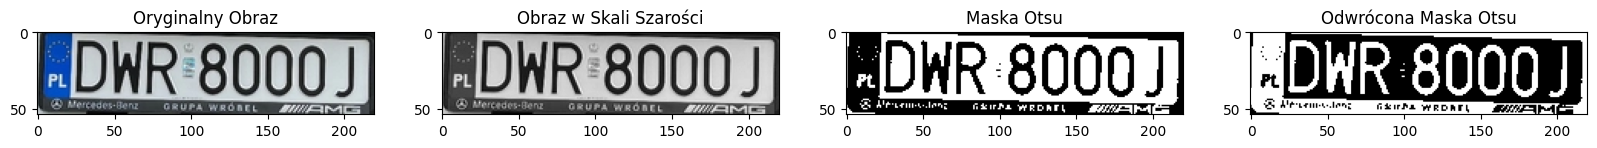

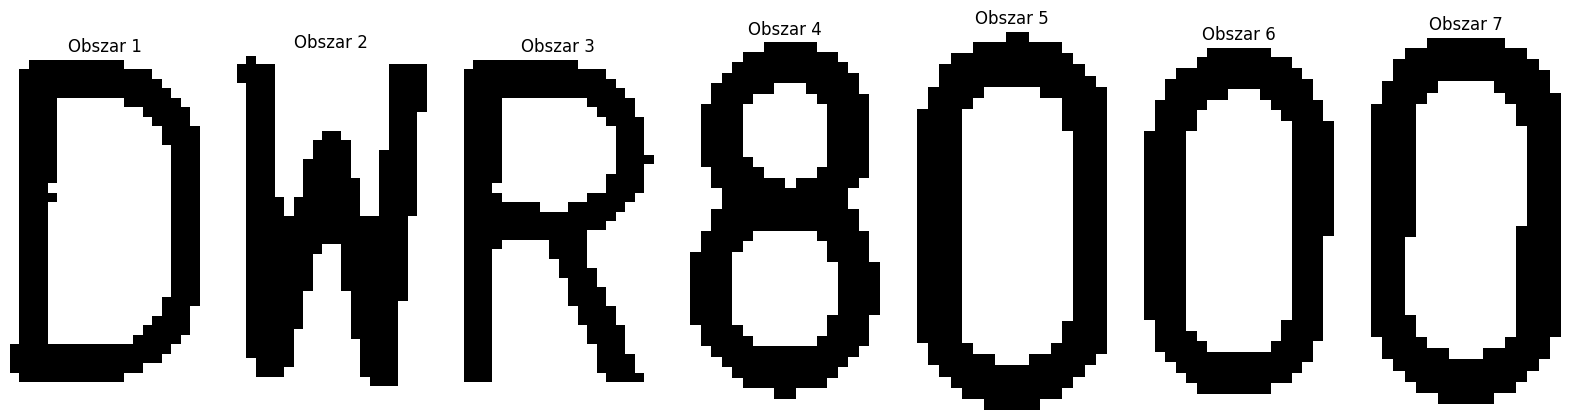

In [143]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Wczytaj obraz
image_path = 'better_data/plate/image_02.png'
image = cv2.imread(image_path)

# Konwersja obrazu na skalę szarości
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Zastosowanie filtru Otsu do progowania
_, otsu_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Odwrócenie maski Otsu
otsu_mask_reversed = cv2.bitwise_not(otsu_mask)

# Znajdź składowe połączone
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(otsu_mask_reversed, connectivity=8)

# Filtruj składowe połączone według ich pól (rozmiarów)
areas = stats[1:, cv2.CC_STAT_AREA]  # Pomiń pierwszy element, który jest tłem
mean_area = np.mean(areas)
std_area = np.std(areas)

lower_bound = mean_area  - std_area * 0.3
upper_bound = mean_area  + std_area * 0.6

# Znajdź i posortuj bounding boxy składowych połączonych według współrzędnej x
filtered_components = []
for i in range(1, num_labels):
    if lower_bound <= stats[i, cv2.CC_STAT_AREA] <= upper_bound:
        x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
        filtered_components.append((x, y, w, h))

filtered_components.sort()  # Sortuj według współrzędnej x

# Wytnij i odwróć obrazy z maski
cropped_masks = []
for x, y, w, h in filtered_components:
    cropped_mask = otsu_mask_reversed[y:y+h, x:x+w]
    cropped_mask_reversed = cv2.bitwise_not(cropped_mask)
    cropped_masks.append(cropped_mask_reversed)

# Opcjonalnie: Pokaż wyniki
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.title('Oryginalny Obraz')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 4, 2)
plt.title('Obraz w Skali Szarości')
plt.imshow(gray_image, cmap='gray')

plt.subplot(1, 4, 3)
plt.title('Maska Otsu')
plt.imshow(otsu_mask, cmap='gray')

plt.subplot(1, 4, 4)
plt.title('Odwrócona Maska Otsu')
plt.imshow(otsu_mask_reversed, cmap='gray')

plt.show()

# Wyświetl wycięte obrazy z odwróconej maski
fig, axes = plt.subplots(1, len(cropped_masks), figsize=(20, 5))
for i, cropped_mask in enumerate(cropped_masks):
    axes[i].imshow(cropped_mask, cmap='gray')
    axes[i].set_title(f'Obszar {i+1}')
    axes[i].axis('off')

plt.show()


In [146]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_image(image_path, save_crops=False,visualize=True):
    # Wczytaj obraz
    image = cv2.imread(image_path)

    # Konwersja obrazu na skalę szarości
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Zastosowanie filtru Otsu do progowania
    _, otsu_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Odwrócenie maski Otsu
    otsu_mask_reversed = cv2.bitwise_not(otsu_mask)

    # Znajdź składowe połączone
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(otsu_mask_reversed, connectivity=8)

    # Filtruj składowe połączone według ich pól (rozmiarów)
    areas = stats[1:, cv2.CC_STAT_AREA]  # Pomiń pierwszy element, który jest tłem
    mean_area = np.mean(areas)
    std_area = np.std(areas)

    lower_bound = mean_area  - std_area * 0.3
    upper_bound = mean_area  + std_area * 0.6

    # Znajdź i posortuj bounding boxy składowych połączonych według współrzędnej x
    filtered_components = []
    for i in range(1, num_labels):
        if lower_bound <= stats[i, cv2.CC_STAT_AREA] <= upper_bound:
            x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            filtered_components.append((x, y, w, h))

    filtered_components.sort()  # Sortuj według współrzędnej x

    # Wytnij i odwróć obrazy z maski
    cropped_masks = []
    for i, (x, y, w, h) in enumerate(filtered_components):
        cropped_mask = otsu_mask_reversed[y:y+h, x:x+w]
        cropped_mask_reversed = cv2.bitwise_not(cropped_mask)
        padding = 5  # Długość boku białego obszaru wokół wyciętego fragmentu
        padded_mask = np.zeros((h + 2 * padding, w + 2 * padding), dtype=np.uint8)
        padded_mask[padding:padding+h, padding:padding+w] = cropped_mask
        padded_mask = cv2.bitwise_not(padded_mask)
        cropped_masks.append(padded_mask)

        # Zapisz każdy wycięty obraz, jeśli opcja zapisu jest ustawiona na True
        if save_crops:
            if not os.path.exists("better_data/crop"):
                os.makedirs("better_data/crop")
                
            if not os.path.exists("better_data/crop/" + image_path.split('/')[-1].split('.')[0]):
                os.makedirs("better_data/crop/" + image_path.split('/')[-1].split('.')[0])
                
            filename = "better_data/crop/" + image_path.split('/')[-1].split('.')[0] + f'/crop_{i+1}.png'
            #print(filename)
            cv2.imwrite(filename, padded_mask)

    # Opcjonalnie: Pokaż wyniki
    if visualize:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.title('Oryginalny Obraz')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        plt.subplot(1, 4, 2)
        plt.title('Obraz w Skali Szarości')
        plt.imshow(gray_image, cmap='gray')

        plt.subplot(1, 4, 3)
        plt.title('Maska Otsu')
        plt.imshow(otsu_mask, cmap='gray')

        plt.subplot(1, 4, 4)
        plt.title('Odwrócona Maska Otsu')
        plt.imshow(otsu_mask_reversed, cmap='gray')

        plt.show()

        # Wyświetl wycięte obrazy z odwróconej maski
        plt.figure(figsize=(20, 5))
        for i, cropped_mask in enumerate(cropped_masks):
            plt.subplot(1, len(cropped_masks), i+1)
            plt.imshow(cropped_mask, cmap='gray')
            plt.title(f'Obszar {i+1}')
            plt.axis('off')

        plt.show()

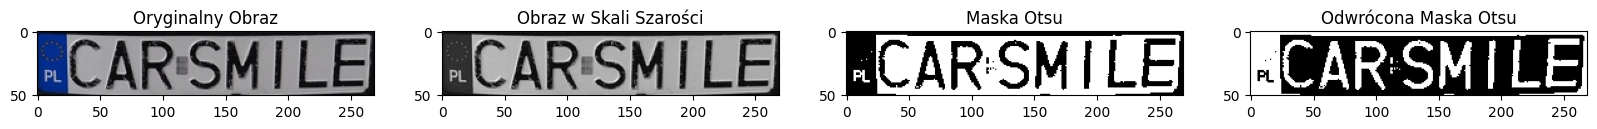

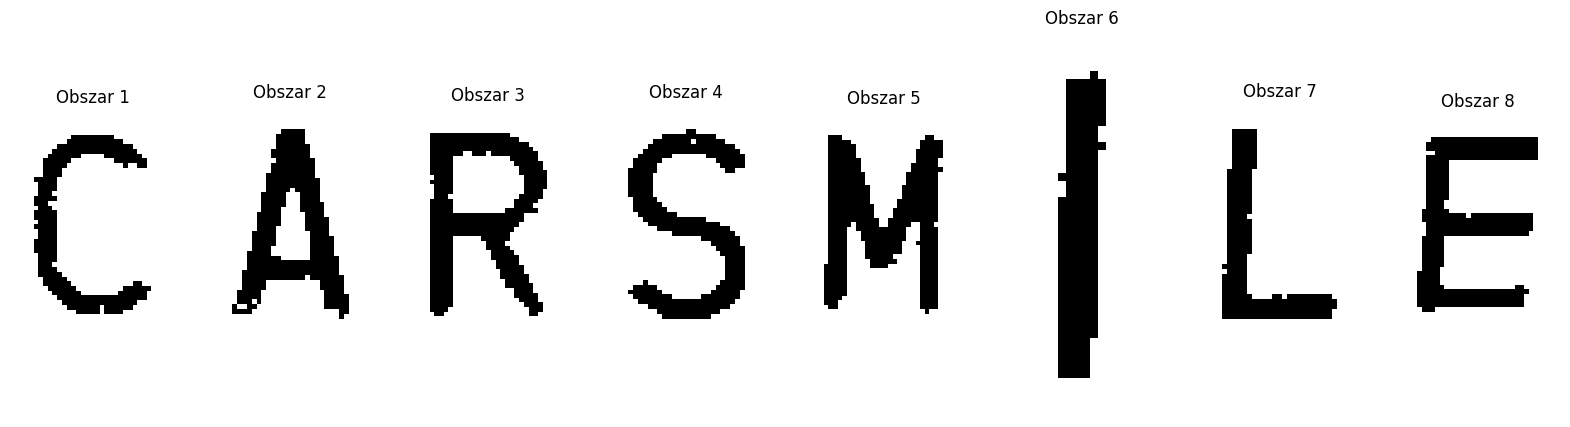

In [140]:
process_image('better_data/plate/image_01.png', save_crops=False, visualize=True)

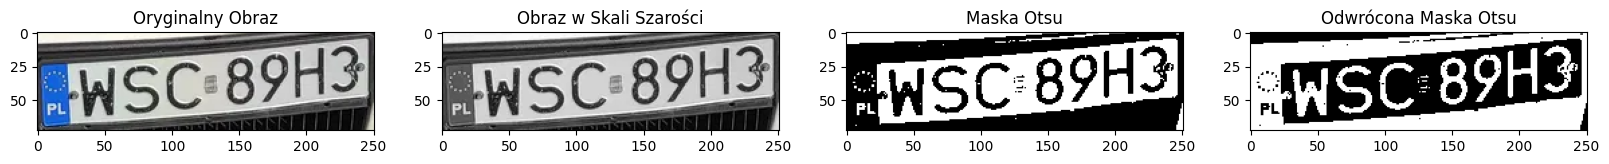

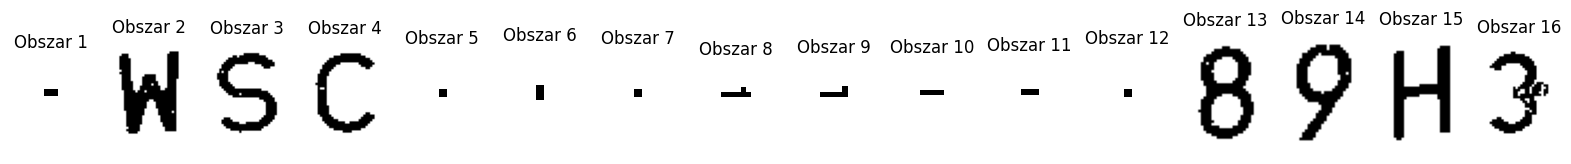

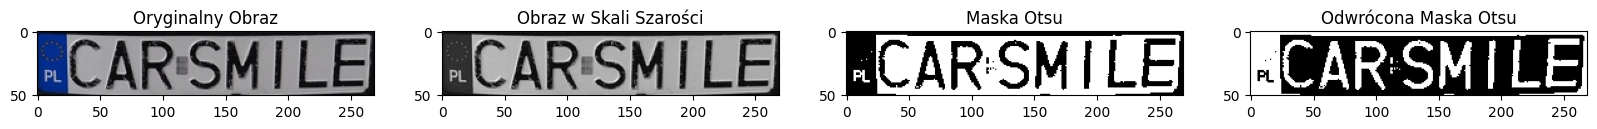

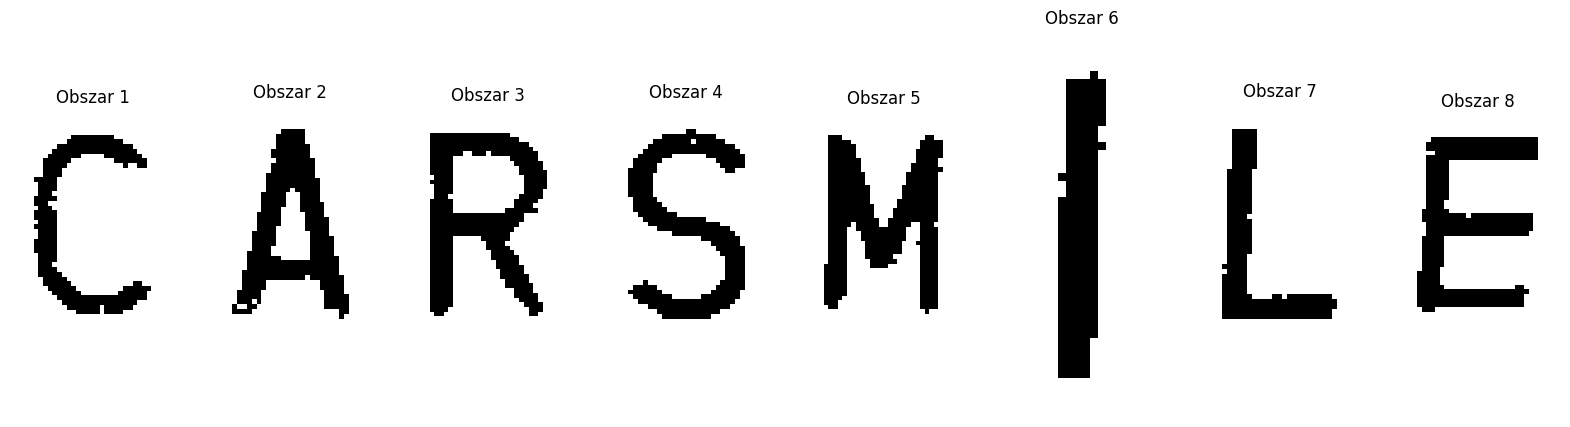

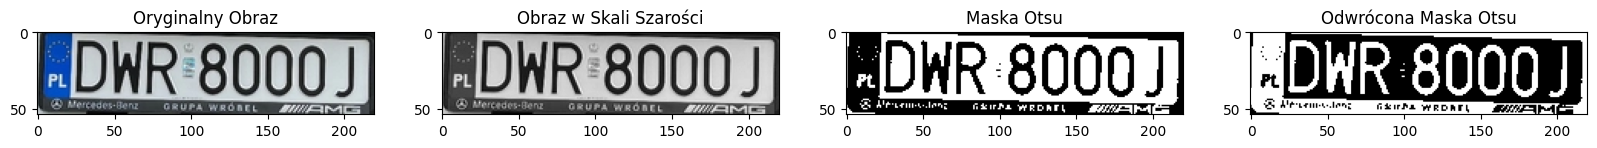

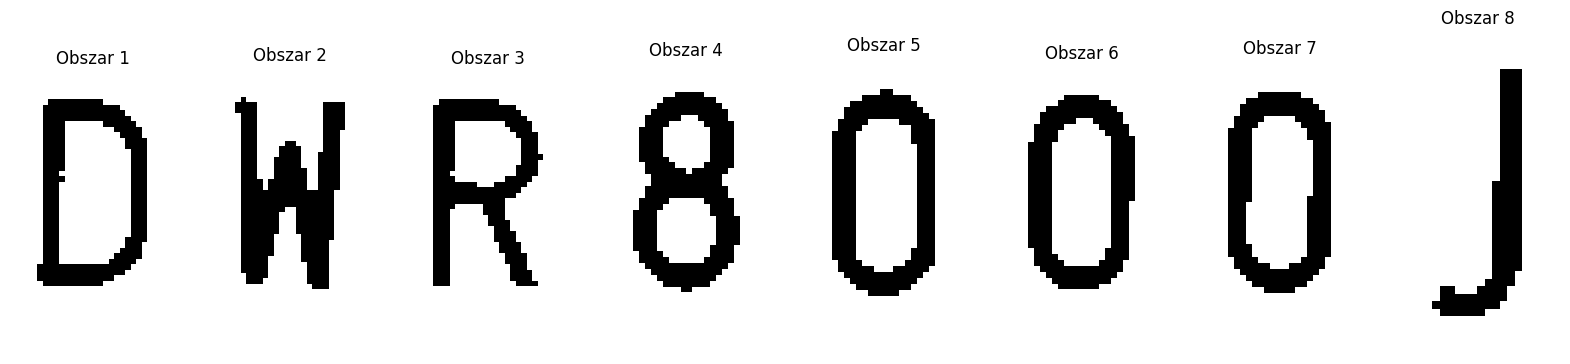

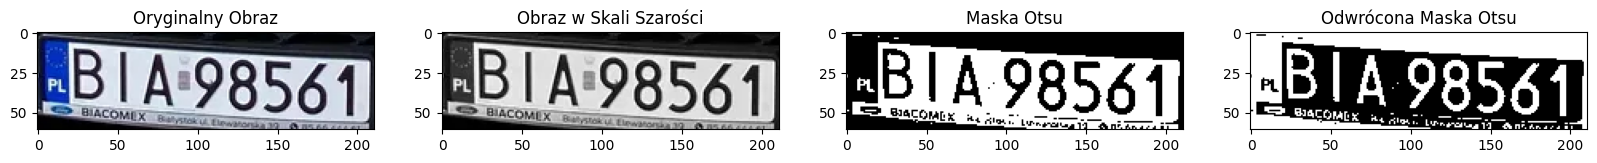

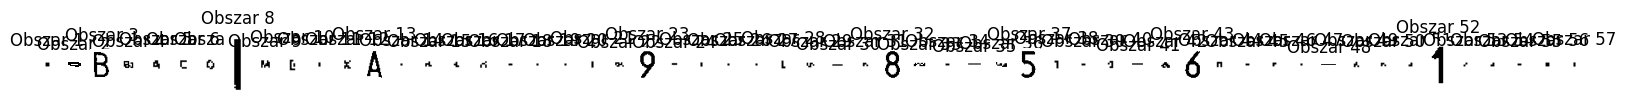

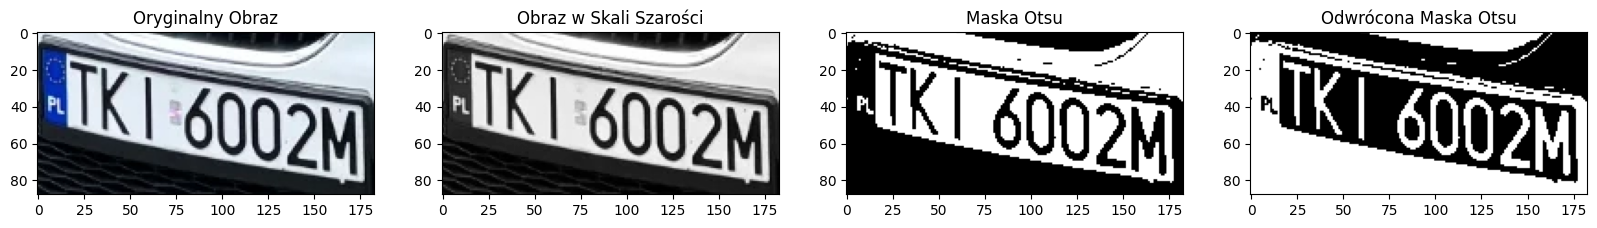

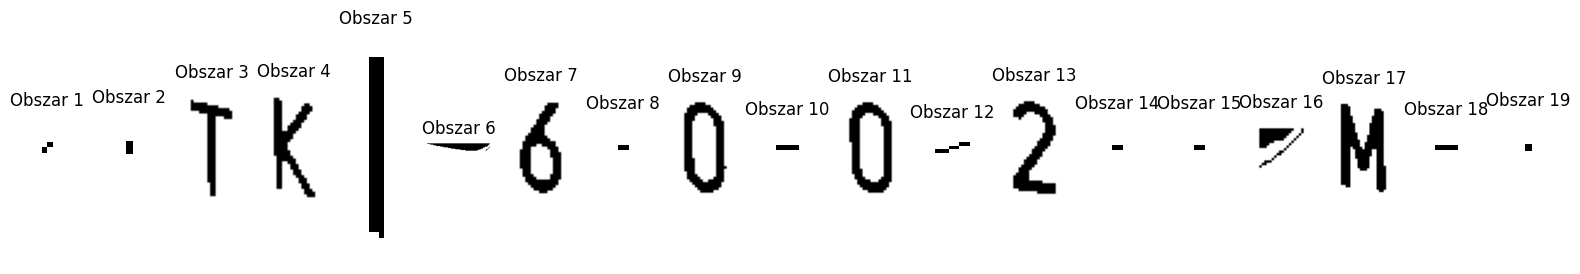

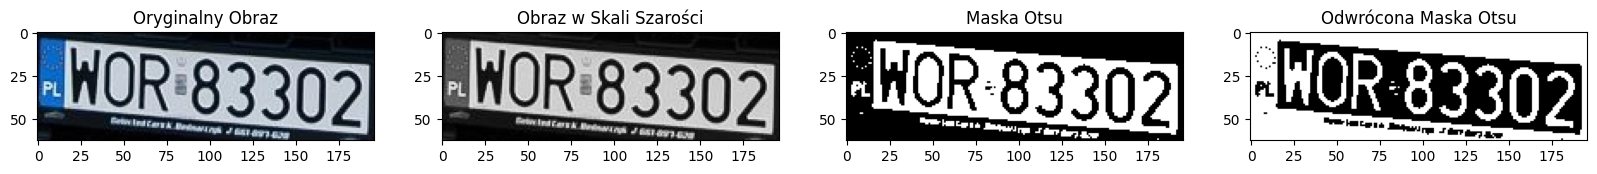

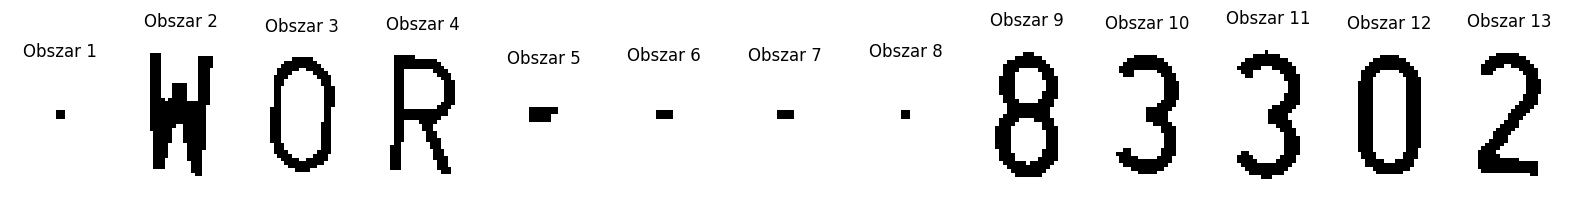

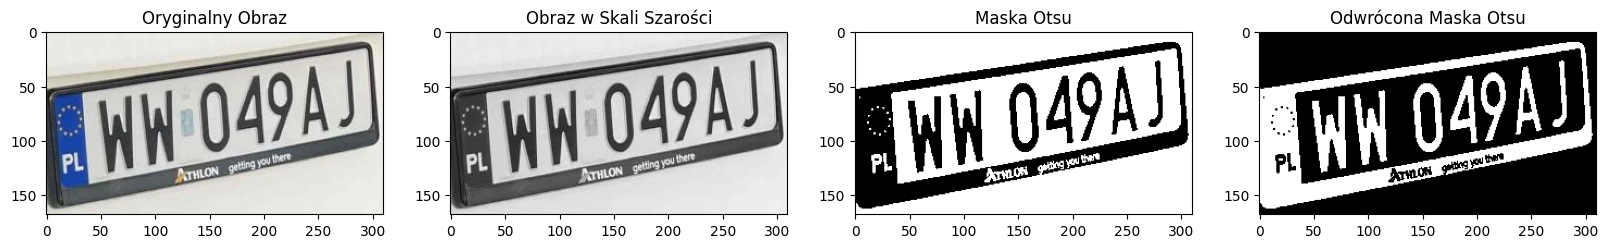

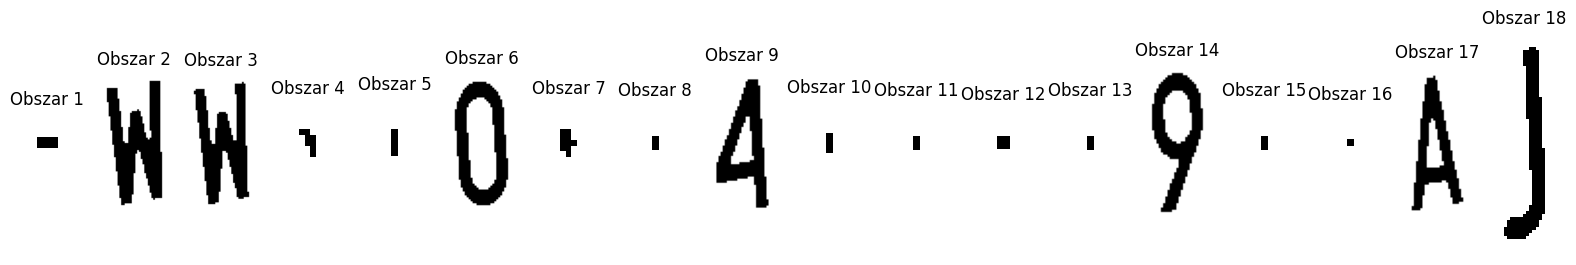

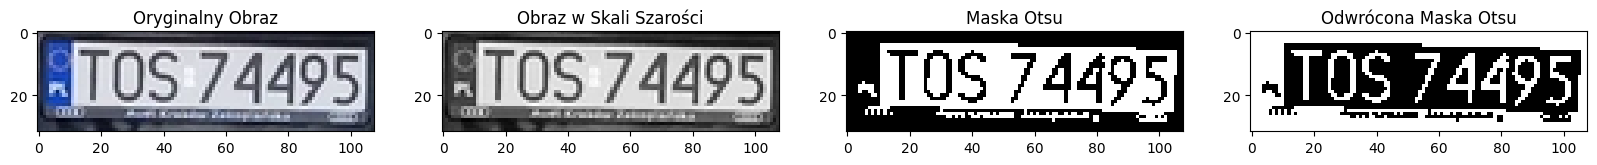

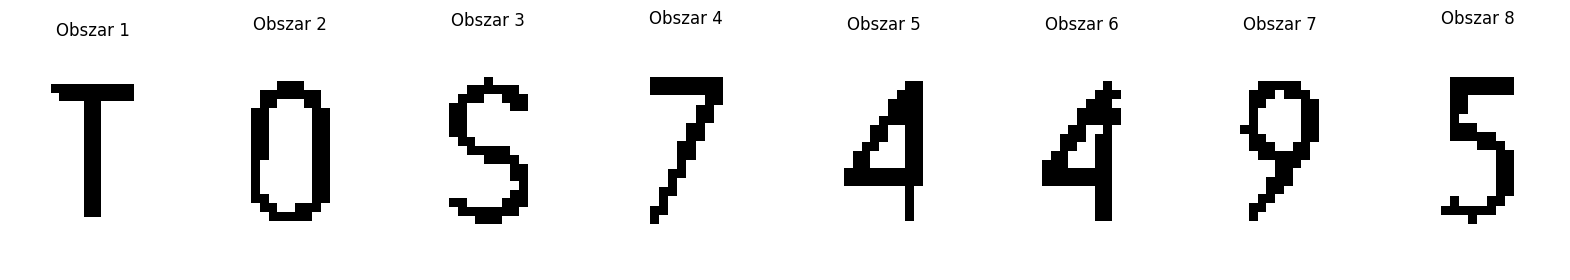

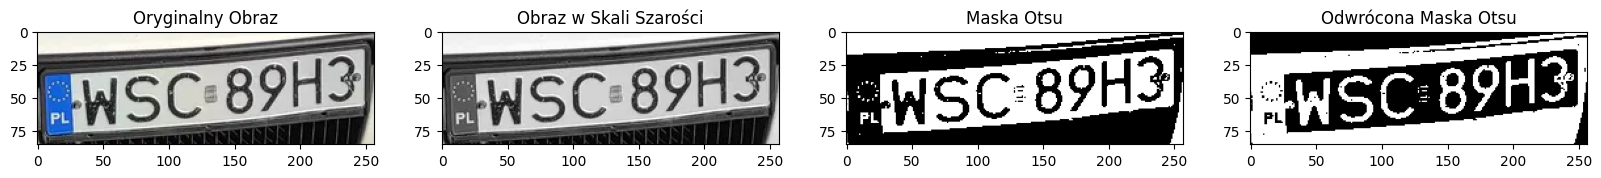

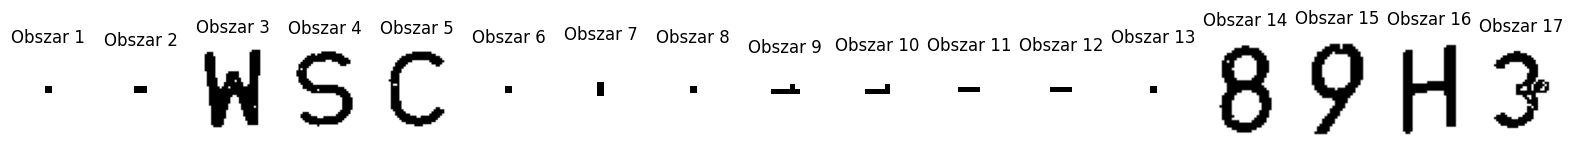

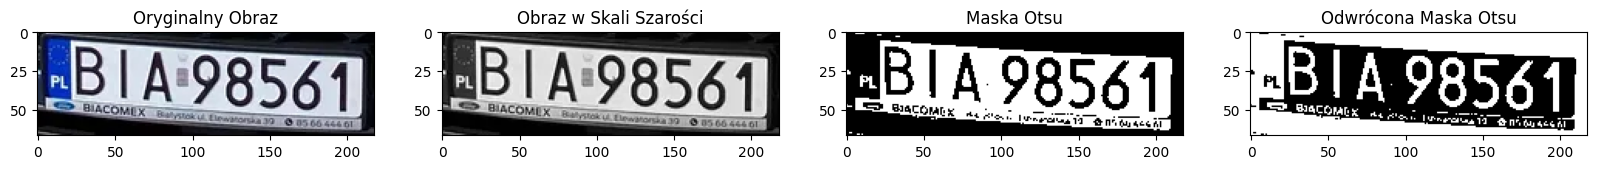

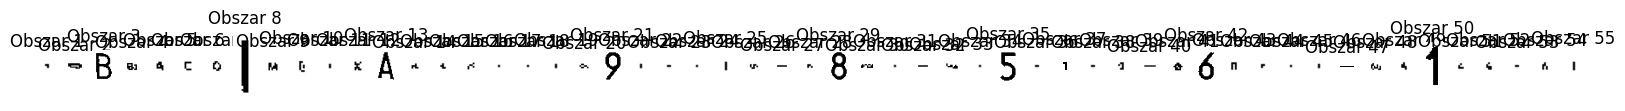

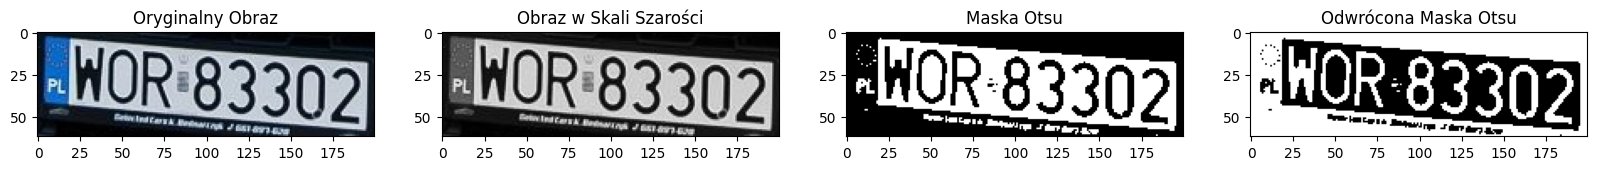

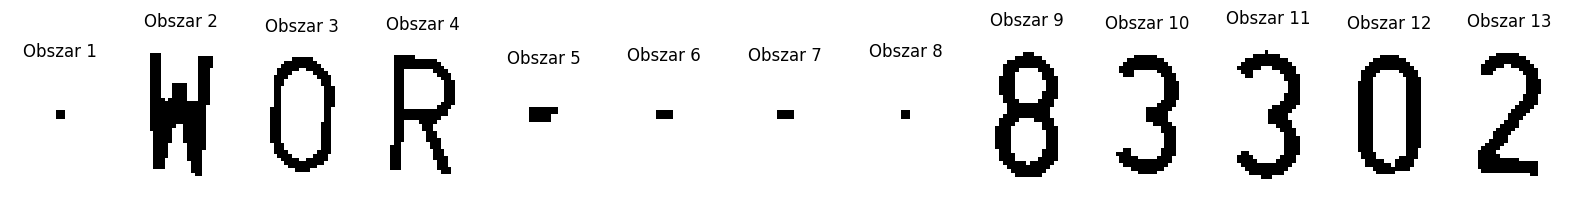

In [148]:
folder_path = 'better_data/plate'
if os.path.exists(folder_path):
    # Pobranie listy plików w folderze
    image_files = [file for file in os.listdir(folder_path) if file.endswith('.png')]
    for image_file in image_files:
        # Tworzenie pełnej ścieżki do pliku
        image_path = os.path.join(folder_path, image_file)
        
        # Wywołanie funkcji process_image dla każdego obrazu
        process_image(image_path, save_crops=True, visualize=True)
else:
    print("Podana ścieżka do folderu nie istnieje.")